In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# df = pd.read_csv(r'C:\Users\Nino\Desktop\Spotify\top50.csv', encoding='latin')
df = pd.read_csv(r'C:\Users\hhamadeh\Documents\Datasets\Spotify\top50.csv', encoding='latin')
df.head()

,Unnamed: 0,Track.Name,Artist.Name,Genre,Beats.Per.Minute,Energy,Danceability,Loudness..dB..,Liveness,Valence.,Length.,Acousticness..,Speechiness.,Popularity
0,1,Señorita,Shawn Mendes,canadian pop,117,55,76,-6,8,75,191,4,3,79
1,2,China,Anuel AA,reggaeton flow,105,81,79,-4,8,61,302,8,9,92
2,3,boyfriend (with Social House),Ariana Grande,dance pop,190,80,40,-4,16,70,186,12,46,85
3,4,Beautiful People (feat. Khalid),Ed Sheeran,pop,93,65,64,-8,8,55,198,12,19,86
4,5,Goodbyes (Feat. Young Thug),Post Malone,dfw rap,150,65,58,-4,11,18,175,45,7,94


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)


Can we predict the popularity of a song based on some of these metrics?

    Energy: The energy of a song - the higher the value, the more energtic. song
    Danceability: The higher the value, the easier it is to dance to this song.
    Loudness (dB): The higher the value, the louder the song.
    Liveness: The higher the value, the more likely the song is a live recording.
    Valence: The higher the value, the more positive mood for the song.
    Length: The duration of the song.
    Acousticness: The higher the value the more acoustic the song is.
    Speechiness: The higher the value the more spoken word the song contains.
    Popularity: The higher the value the more popular the song is.

In [4]:
df.columns = ['Track', 'Artist', 'Genre', 'BPM', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence',
        'Length', 'Acousticness', 'Speechiness', 'Popularity']

In [5]:
# Check if there are any nulls
df.isnull().any()

Track            False
Artist           False
Genre            False
BPM              False
Energy           False
Danceability     False
Loudness (dB)    False
Liveness         False
Valence          False
Length           False
Acousticness     False
Speechiness      False
Popularity       False
dtype: bool

In [6]:
# Number of unique artists in top 50
df['Artist'].nunique()

38

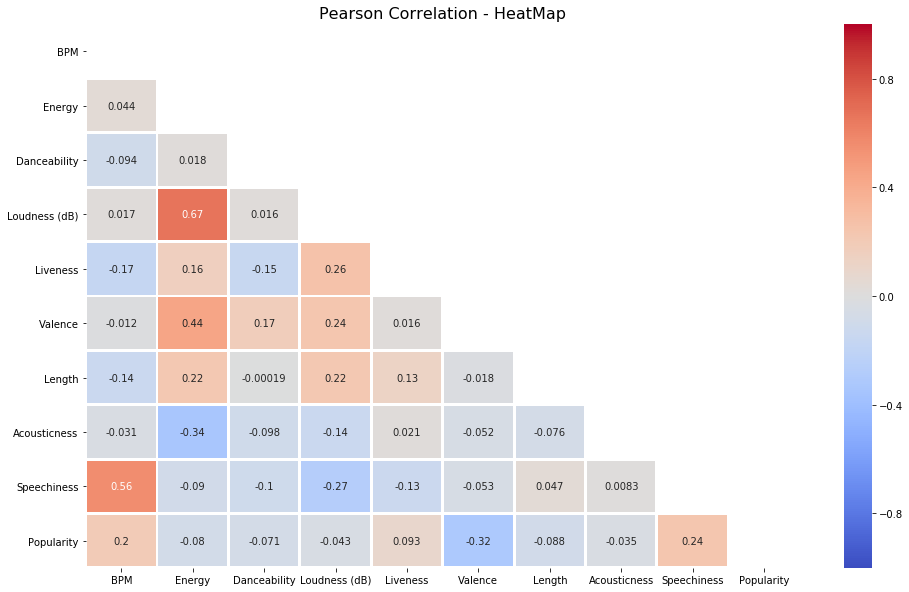

In [7]:
#### Pearson Correlation of Features
dfCorr = df[['BPM', 'Energy', 'Danceability', 'Loudness (dB)', 'Liveness', 'Valence',
        'Length', 'Acousticness', 'Speechiness', 'Popularity']].corr(method='pearson')


# Since a heatmap is mirrored along the diagnol, we can filter out the top half to make it nicer on the eyes
mask = np.zeros_like(dfCorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(16, 10))
ax = sns.heatmap(dfCorr,
           cmap='coolwarm',         # Hotter = Positive, Colder = Negative
           annot=True,
                 vmin=-1,           # set the minimum value of the color scale to -1
                linewidths=2,
                linecolor='white',
                mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Pearson Correlation - HeatMap", size=16)
ax.tick_params(axis='both', which='major', rotation=0, labelsize=10)

Strong correlation between Energy and Loudness (dB).

Popularity and Speechiness/BPM have an interesting result in this heatmap as well.

Things to consider:

1. Energy vs Loudness
2. Beats Per Minute vs Speechiness
3. Genre vs Popularity


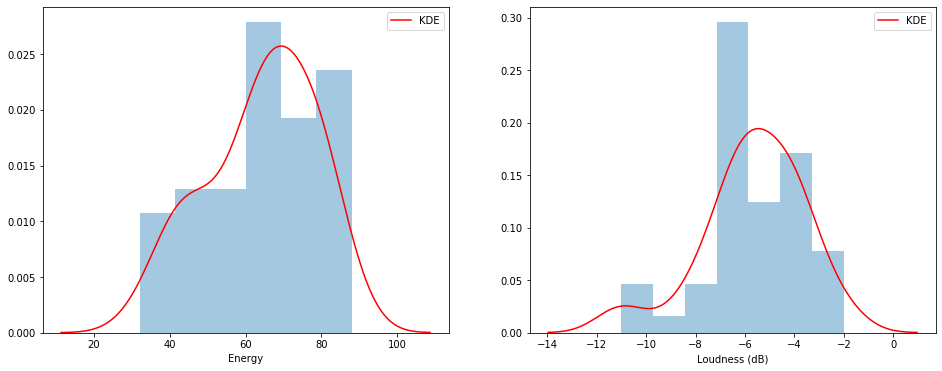

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(df['Energy'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[0])
sns.distplot(df['Loudness (dB)'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[1])

In [ ]:
# Let's see if we can make a nicer gaussian
skew = df[['Energy', 'Loudness (dB)']].skew()
print(skew)

# Box Cox Transformations (to reduce skew)
energyXF = np.asarray(df['Energy'])
loudnessXF = np.asarray(abs(df['Loudness (dB)']))

e1 = stats.boxcox(energyXF)[0]
l1 = stats.boxcox(loudnessXF)[0]

transformed = pd.DataFrame({'Energy' : e1, 'Loudness (dB)' : l1})
transformed['Loudness (dB)'] = transformed['Loudness (dB)'].apply(lambda x: -abs(x))

print(transformed.skew())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.distplot(transformed['Energy'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[0])
sns.distplot(transformed['Loudness (dB)'], kde=True, rug=False, kde_kws={'color' : 'r', 'label' : 'KDE'},
             ax=ax[1])

In [9]:
# Split data into 80/20 train/test split

from sklearn.model_selection import train_test_split, cross_val_score

X = df[['Energy', 'Loudness (dB)']]
# X = df[['Energy', 'Danceability']]
y = df['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [10]:
# Linear Regression

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print(reg.intercept_)
print(reg.coef_)

92.37082645179866
[-0.0568555   0.19302495]


In [11]:
y_pred = reg.predict(X_test)

df_output = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_output)

    Actual  Predicted
41      90  87.346502
15      82  88.461154
45      88  88.459735
17      91  88.483613
39      78  88.028769
20      91  86.812345
33      89  87.665177
11      86  87.561986
10      93  87.880660
22      83  87.107142


In [12]:
reg.predict([[55, -6]])

array([88.08562403])

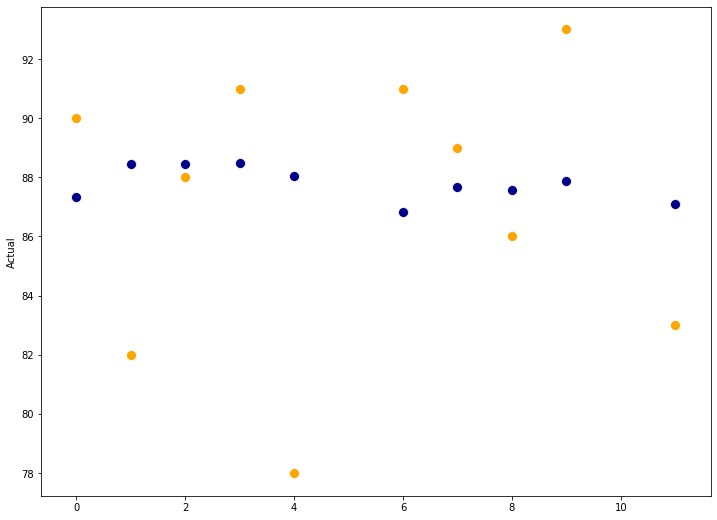

In [13]:
space = np.linspace(0, 11, 10, dtype=int)


plt.figure(figsize=(12, 9))
sns.scatterplot(x=space, y=df_output['Predicted'], color='darkblue', s=100)
sns.scatterplot(x=space, y=df_output['Actual'], color='orange', s=100)

In [14]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.8430488616242484
Mean Squared Error: 22.0741584295453
Root Mean Squared Error: 4.698314424295728


In [15]:
# Cross Validation Score
# Linear Regression

reg = LinearRegression()
mse = cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# The sum of squared errors (MSE) for each of 5 CVs
print(mse)

mse_mean = np.mean(mse)
print("\nAverage of Mean Squared Error: {}\n".format(mse_mean))

diff = metrics.mean_squared_error(y_test, y_pred) - abs(mse_mean)
print("Difference between inital and CV score: {}".format(diff))


[-14.78109924 -19.14714316 -44.00317303 -11.27234369 -21.39838177]

Average of Mean Squared Error: -22.12042817872492

Difference between inital and CV score: -0.04626974917962201


#### Predicting Song Genre

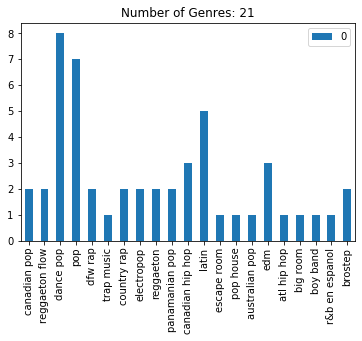

In [16]:
from collections import Counter

genres = Counter(df['Genre'])
g = pd.DataFrame.from_dict(genres, orient='index')
g.plot(kind='bar', title='Number of Genres: {}'.format(df['Genre'].nunique()))

In [ ]:
list(df['Genre'].unique())

In [17]:
# Determine number of pop and hiphop/rap songs 

p = df['Genre'].str.contains(pat='pop')
r = df['Genre'].str.contains(pat='hip hop|rap')
reg = df['Genre'].str.contains(pat='reggaeton')
edm = df['Genre'].str.contains(pat='edm|big room')

print('Pop: {}({:.1%})\nRap: {}({:.1%})\nReggae: {}({:.1%})\nEDM: {}({:.1%})'.format(len(p.loc[p]), 
                                                                                     len(p.loc[p])/df['Genre'].shape[0], 
                                                                    len(r.loc[r]), 
                                                                                     len(r.loc[r])/df['Genre'].shape[0],
                                                                   len(reg.loc[reg]), 
                                                                                     len(reg.loc[reg])/df['Genre'].shape[0],
                                                                   len(edm.loc[edm]), 
                                                                                     len(edm.loc[edm])/df['Genre'].shape[0]))

Pop: 23(46.0%)
Rap: 9(18.0%)
Reggae: 4(8.0%)
EDM: 4(8.0%)


In [18]:
# Rename songs to simplify categories

df['Genre'][p] = 'pop'
df['Genre'][r] = 'rap'
df['Genre'][reg] = 'reggaeton'
df['Genre'][edm] = 'edm'

C:\Users\Nino\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nino\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Nino\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

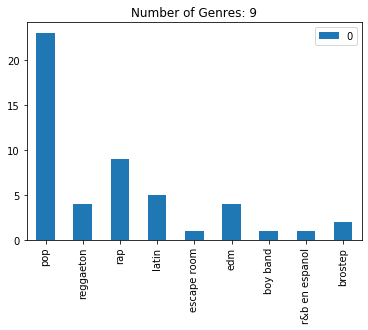

In [19]:
from collections import Counter

genres = Counter(df['Genre'])
g = pd.DataFrame.from_dict(genres, orient='index')
g.plot(kind='bar', title='Number of Genres: {}'.format(df['Genre'].nunique()))

In [ ]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x=df['Liveness'], y=df['Energy'], s=abs(df['Loudness (dB)']) * 10, hue=df['Genre'])

In [20]:
# Label Encode Genres
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encodedGenres = le.fit_transform(df['Genre'])

In [23]:
df['encodedGenre'] = encodedGenres

In [28]:
Xclass = df[['Liveness', 'Energy', 'Loudness (dB)']]
yclass = df['encodedGenre']


from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(Xclass, yclass, test_size=0.2, random_state=42)

In [29]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
predictGNB = clf.predict(X_test)

GNBoutput = pd.DataFrame({'Predicted' : predictGNB, 'Actual' : y_test})

GNBoutput

,Predicted,Actual
13,5,5
39,5,5
30,7,2
45,4,1
17,7,7
48,4,2
26,5,5
25,8,5
32,5,8
19,5,3


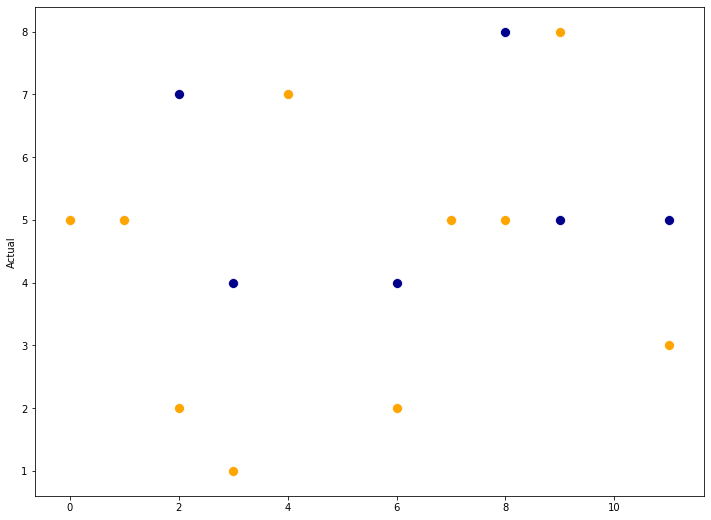

In [34]:
space = np.linspace(0, 11, 10, dtype=int)


plt.figure(figsize=(12, 9))
sns.scatterplot(x=space, y=GNBoutput['Predicted'], color='darkblue', s=100)
sns.scatterplot(x=space, y=GNBoutput['Actual'], color='orange', s=100)

In [42]:
clf.predict([[11, 65, -4]])

array([8])

In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, shuffle=True, random_state=42)
kf.get_n_splits(Xclass)

2

In [ ]:
# Label Encode
df.columns

In [ ]:
Xdouble = df[['Energy', 'Loudness (dB)', 'Valence']]

In [ ]:
# PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pca = PCA().fit(Xdouble)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We need at least 1 dimensions to retain ~90% of the variance.

In [ ]:
pca = PCA(1) # Project from 3 to 1 dimensions
pca.fit(Xdouble)
# projected = pca.fit_transform(Xdouble)
X_pca = pca.transform(Xdouble)

print(Xdouble.shape)
print(X_pca.shape)

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
len(digits.target)

### Exclude for now

In [ ]:
# PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
pca = PCA()
X_reduced = pca.fit_transform(scale(Xdouble))


In [ ]:
# Variance ratio of first 2 componenets
pca.explained_variance_ratio_

In [ ]:
# Sum of first 2 componenets equals 100%
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

In [ ]:
# pca.components_

In [ ]:
from sklearn import cross_validation

n = len(Xdouble)
kf_5 = cross_validation.KFold(n, n_folds=5, shuffle=True, random_state=2)

regr = LinearRegression()
mse = []



In [ ]:
score = -1 * cross_validation.cross_val_score(regr, np.ones((n, 1)), y.ravel(), cv=kf_5, 
                                              scoring='neg_mean_squared_error').mean()  
                                              
mse.append(score) 

In [ ]:
for i in np.arange(1,6):
    score = -1 * cross_validation.cross_val_score(regr, Xdouble, y.ravel(), cv=kf_5, 
                                                scoring='neg_mean_squared_error').mean()
    mse.append(score)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(mse, '-v')
ax2.plot([1,2,3,4,5], mse[1:6], '-v')
ax2.set_title('Intercept excluded from plot')

for ax in fig.axes:
    ax.set_xlabel('Number of principal components in regression')
    ax.set_ylabel('MSE')
    ax.set_xlim((-0.2,5.2))

In [ ]:
# PLS Regression
from sklearn.cross_decomposition import PLSRegression


mse = []

kf_5 = cross_validation.KFold(n, n_folds=5, shuffle=True, random_state=2)

for i in np.arange(1, 6):
    pls = PLSRegression(n_components=1, scale=False)
    pls.fit(scale(X_reduced), y)
    score = cross_validation.cross_val_score(pls, X_reduced, y, cv=kf_5, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
    
plt.plot(np.arange(1, 6), np.array(mse), '-v')
plt.xlabel('Number of principal components in PLS Regression')
plt.ylabel('MSE')
plt.xlim((-0.2, 5.2))
    